## Portfolio Exercise Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their candidates.   The data for this exercise consists of about 120,000 data points split in 2:1 ratio among training and test files. Each data point includes one column indicating whether or not an individual was sent a promotion for a specific product, and one column indicating whether or not that individual eventually purchased that product. Each individual also had seven additional features associated with them.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user.  Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

Ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group.

* **Net Incremental Revenue (NIR)**

The total number of purchasers that received the promotion times 10 minus the number of promotions given times 0.15 minus the number of purchasers who were not given the promotion times 10.

For a full description of what starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the **promotion_strategy** function to pass to the **test_results** function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers.  

|   | Actual      |    |    | 
|---|-------------|----|----|
| **Predicted**   | Yes| No |  
| Yes             | **I**   | **II**|  
| No              | **III** | **IV**|  

The metrics are only being compared for the individual's we predict should obtain the promotion - that is quadrants I and II here.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equal participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 


Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final test_results function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import researchpy as rp
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

# load in the data
train_data = pd.read_csv('./data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


## Explorative Data Analysis

In [2]:
# Mapping 'Promotion' column data to integers.
train_data.Promotion = train_data.Promotion.map({'Yes': 1, 'No': 0})

In [3]:
# Make categorical and numerical columns lists.
cat_columns = ['V1', 'V4', 'V5', 'V6', 'V7']
num_columns = ['V2', 'V3']

In [4]:
train_data[cat_columns] = train_data[cat_columns].astype('category')

In [5]:
# check for missing values
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [6]:
# Summary of numerical columns.
train_data.describe()

,ID,Promotion,purchase,V2,V3
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.501147,0.012303,29.973600,0.000190
std,36418.440539,0.500002,0.110234,5.010626,1.000485
min,1.000000,0.000000,0.000000,7.104007,-1.684550
25%,31467.250000,0.000000,0.000000,26.591501,-0.905350
50%,62827.500000,1.000000,0.000000,29.979744,-0.039572
75%,94438.750000,1.000000,0.000000,33.344593,0.826206
max,126184.000000,1.000000,1.000000,50.375913,1.691984


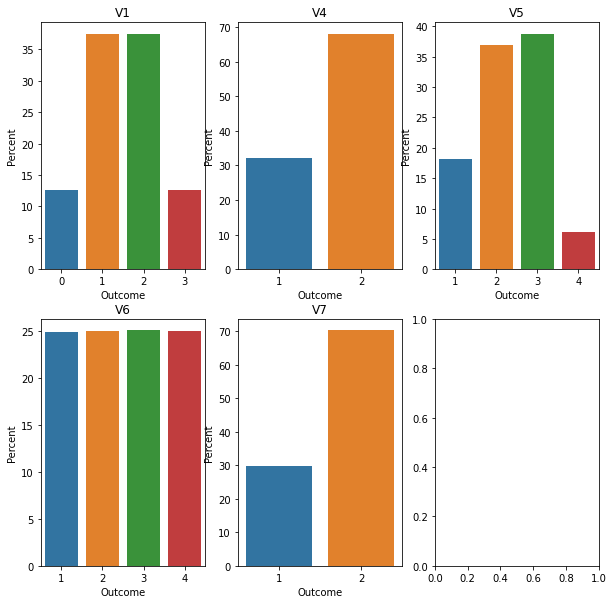

In [7]:
# Summary of categorical columns.
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for a, col in zip(axes.flatten(), cat_columns):
    df = rp.summary_cat(train_data[col])[['Outcome', 'Percent']].sort_values('Outcome')
    sb.barplot(x='Outcome', y='Percent', data=df, ax=a)
    a.set_title(col)
plt.show()

In [8]:
# Counts of customers grouped by promotion
train_data['Promotion'].value_counts()

1    42364
0    42170
Name: Promotion, dtype: int64

In [9]:
# Counts of customers grouped by purchase and promotion
train_data.groupby(['purchase', 'Promotion'])['ID'].count()

purchase  Promotion
0         0            41851
          1            41643
1         0              319
          1              721
Name: ID, dtype: int64

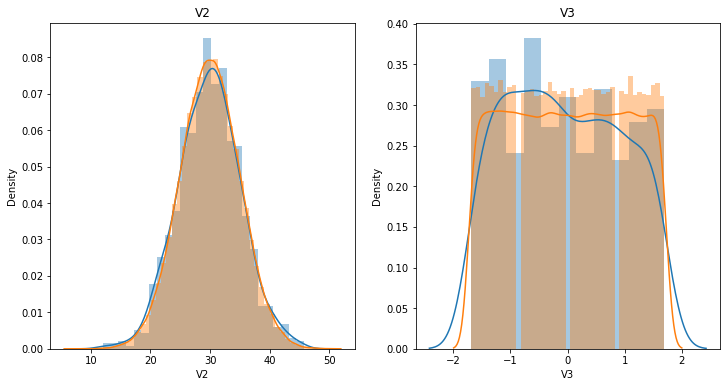

In [10]:
# Distribution plot of numerical columns grouped by purchase
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, col in zip(axes.flatten(), num_columns):
    sb.distplot(a=train_data[train_data.purchase==1][col], ax=ax)
    sb.distplot(a=train_data[train_data.purchase==0][col], ax=ax)
    ax.set_title(col)

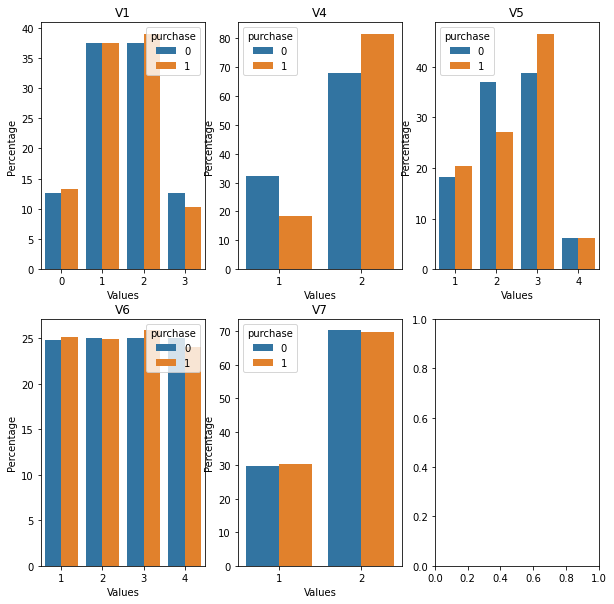

In [11]:
# Percentage plot of categorical columns grouped by purchase
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

for ax, col in zip(axes.flatten(), cat_columns):
    percentage_df = train_data.groupby(['purchase'])[col].value_counts(normalize=True).mul(100).round(2).reset_index().sort_values(['purchase', 'level_1'])
    sb.barplot(x='level_1', y=col, hue='purchase', data=percentage_df, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Values')

## Check Invariant Metric

Null hypothesis is that the number of customers of the control group does not show statistical difference with the number of customers of the treatment group.  
We can assume that they are randomly chosen by the binomial probability of 0.5.

In [12]:
# Statistical approach
n = train_data.shape[0]
n_prom = train_data[train_data.Promotion==1].shape[0]
n_non_prom = n - n_prom
p = 0.5
sd = np.sqrt(p * (1-p) * n)
z = ((n_non_prom + 0.5) - 0.5 * n) / sd
p_value = 2 * sp.stats.norm.cdf(z)
print('p_value: ', p_value)

p_value:  0.5068140685419046


In [13]:
# Bootstrapping approach
n_trials = 5000
n_points = train_data.shape[0]
sample_diffs = []

for i in range(n_trials):
    sample = train_data.sample(n_points, replace=True)
    sample_diff = sample[sample.Promotion==1].shape[0] - sample[sample.Promotion==0].shape[0]
    sample_diffs.append(sample_diff)

lower_lim = np.percentile(sample_diffs, (1 - 0.95) / 2 * 100)
upper_lim = np.percentile(sample_diffs, (1 + 0.95) / 2 * 100)
print("Confidence Intervals of 95% \n",
    "Lower Limit: ", lower_lim, "\n",
    "Upper Limit: ", upper_lim)
 
std = np.std(sample_diffs)
z = ((n_non_prom - n_prom) - 0) / std
p_value = 2 * sp.stats.norm.cdf(z)
print("p-value: ", p_value)

Confidence Intervals of 95% 
 Lower Limit:  -392.0499999999998 
 Upper Limit:  756.0
p-value:  0.5095197081103462


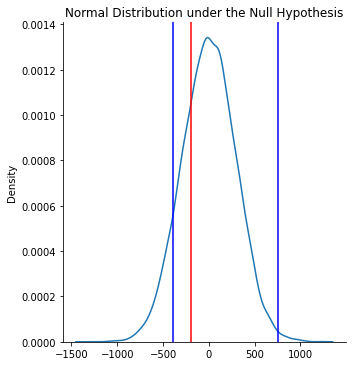

In [14]:
random_values = np.random.normal(loc=0, scale=std, size=20000)
sb.displot(random_values, kind='kde')
plt.title("Normal Distribution under the Null Hypothesis")
plt.axvline(n_non_prom - n_prom, color='r', label='Observed difference')
plt.axvline(upper_lim, color='b')
plt.axvline(lower_lim, color='b')

Given the p_value, we **Fail to reject the null hypothesis**.  
The difference in the invariant metric isn't statistically significant.

So we can proceed to check the evaluation metrics

## Calculate Evaluation Metrics

In [15]:
def IRR(promotion, purchase):
    """
    Calculate Incremental Response Rate(IRR).
       
    Args:
    promotion: array-like, values with 0 and 1 (0 for control, 1 for treat group).
    purchase:  array-like, values with 0 and 1 (0 for negative, 1 for positive).

    Return:
    IRR: purchase_treat/customer_treat - purchase_control/customer_control
    """
    contingency_table = pd.crosstab(promotion, purchase)
    treat_ratio = contingency_table.iloc[1, 1] / contingency_table.iloc[1, :].sum()
    control_ratio = contingency_table.iloc[0, 1] / contingency_table.iloc[0, :].sum()
    return treat_ratio - control_ratio

def NIR(promotion, purchase):
    """
    Calculate Net Incremental Revenue(NIR).
       
    Args:
    promotion: array-like, values with 0 and 1 (0 for control, 1 for treat group).
    purchase:  array-like, values with 0 and 1 (0 for negative, 1 for positive).

    Return:
    NIR: (10 * purchase_treat - 0.15 * customer_treat) - 10 * purchase_control
    """
    
    contingency_table = pd.crosstab(promotion, purchase)
    promotion_rev = 10 * contingency_table.iloc[1, 1] - 0.15 * contingency_table.iloc[1, :].sum()
    non_promotion_rev = 10 * contingency_table.iloc[0, 1]
    return promotion_rev - non_promotion_rev    

In [16]:
# IRR value of the given data.
irr = IRR(train_data.Promotion, train_data.purchase)
print('IRR: ', irr)

IRR:  0.009454547819772702


In [17]:
# NIR value of the given data.
nir = NIR(train_data.Promotion, train_data.purchase)
print('NIR: ', nir)

NIR:  -2334.5999999999995


In [18]:
# IRR with Bonferroni Correction
# Null hypothesis: IRR = 0
# Alternative hypothesis: IRR > 0
# Bootstrapping

n_trial = 5000
n_points = train_data.shape[0]
sample_irrs = []

for i in range(n_trial):
    sample = train_data.sample(n_points, replace=True)
    sample_irr = IRR(sample.Promotion, sample.purchase)
    sample_irrs.append(sample_irr)

lower_lim = np.percentile(sample_irrs, (1 - 0.975) / 2 * 100)
upper_lim = np.percentile(sample_irrs, (1 + 0.975) / 2 * 100)

print("Confidenct Interval of 97.5% \n",
    "Lower Limit: ", lower_lim, "\n" 
    "Upper Limit: ", upper_lim)

z = (irr - 0) / np.std(sample_irrs)
p_value = 1 - sp.stats.norm.cdf(z)
print('p-value: ', p_value)

Confidenct Interval of 97.5% 
 Lower Limit:  0.007665751498852316 
Upper Limit:  0.011187222810329887
p-value:  0.0


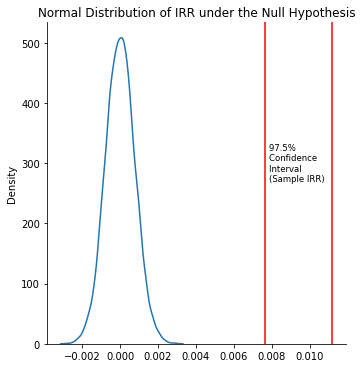

In [19]:
random_irrs = np.random.normal(0, np.std(sample_irrs), 20000)
sb.displot(random_irrs, kind='kde')
plt.title("Normal Distribution of IRR under the Null Hypothesis")
plt.axvline(upper_lim, color='r')
plt.axvline(lower_lim, color='r')
plt.text(lower_lim+0.0002, 300, '97.5% \nConfidence \nInterval \n(Sample IRR) ', va='center', size=8.5)
plt.show()

Given the p-value, we can reject the null hypothesis.  
This means the experiment has shown **statistically significant improvement of IRR metric result**.

In [20]:
# NIR with Bonferroni Correction
# Null hypothesis: NIR = 0
# Alternative hypothesis: NIR > 0
# Bootstrapping

In [21]:
n_trials = 5000
n_points = train_data.shape[0]
sample_nirs = []

for i in range(n_trials):
    sample = train_data.sample(n_points, replace=True)
    sample_nir = NIR(sample.Promotion, sample.purchase)
    sample_nirs.append(sample_nir)

lower_lim = np.percentile(sample_nirs, (1 - 0.975) / 2 * 100)
upper_lim = np.percentile(sample_nirs, (1 + 0.975) / 2 * 100)

print("Confidenct Interval of 97.5% \n",
    "Lower Limit: ", lower_lim, "\n" 
    "Upper Limit: ", upper_lim)
z = (nir - 0) / np.std(sample_nirs)
p_value = 1 - sp.stats.norm.cdf(z)
print("p-value: ", p_value)

Confidenct Interval of 97.5% 
 Lower Limit:  -3053.3712499999997 
Upper Limit:  -1611.9525000000003
p-value:  0.9999999999996839


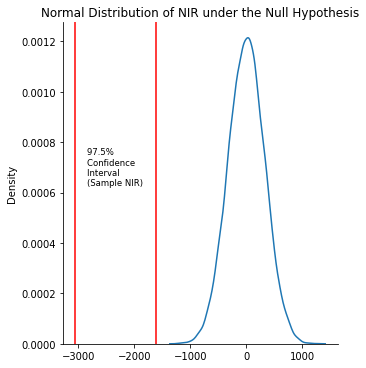

In [22]:
random_nirs = np.random.normal(0, np.std(sample_nirs), 20000)
sb.displot(random_nirs, kind='kde')
plt.title("Normal Distribution of NIR under the Null Hypothesis")
plt.axvline(upper_lim, color='r')
plt.axvline(lower_lim, color='r')
plt.text(x=lower_lim+200, y=0.0007, s='97.5% \nConfidence \nInterval \n(Sample NIR) ', va='center', size=8.5)
plt.show()

The p-value is almost 1, so we fail to reject the null hypothesis.  
This means the experiment does not show statistically significant imporvement of NIR metric on sample data.

## Modeling

So randomization at selecting customers for promotion cannot be applied to real world.  
We should test whether machine learning models that can predict the customers who's going to purchase can increase the evaluation metrics  
with statistical significance.

In [62]:
# load in the data
train_data = pd.read_csv('./data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [63]:
# Select features and target variable
X = train_data.drop(labels=['ID', 'Promotion', 'purchase'], axis=1)
y = train_data.purchase

In [64]:
# train_test_split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [65]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    y_pred = model.predict(df)
    promotion = np.array(list(map(lambda x: 'Yes' if x==1 else 'No', y_pred)))
       
    return promotion

#### 1. RandomForestClassifier

In [66]:
# Instantiate model
model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight='balanced_subsample')

In [67]:
# Train model
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_estimators=200)

In [70]:
# Predict test data and get F1 score
y_pred = model.predict(X_test)
print(str(model), " F1 score: ", f1_score(y_test, y_pred, average='weighted'))

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_estimators=200)  F1 score:  0.7317296598324108


In [69]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.02.

Your nir with this strategy is 330.20.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


(0.019016676897594714, 330.20000000000005)

#### 2. EasyEnsembleClassifier

In [38]:
# Instantiate model
model = EasyEnsembleClassifier(sampling_strategy='all', replacement=True)

In [39]:
# Train model
model.fit(X_train, y_train)

EasyEnsembleClassifier(replacement=True, sampling_strategy='all')

In [40]:
# Predict test data and calculate F1 score
y_pred = model.predict(X_test)
print(str(model), " F1 score: ", f1_score(y_test, y_pred, average='weighted'))

EasyEnsembleClassifier(replacement=True, sampling_strategy='all')  F1 score:  0.031702062172976296


In [41]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.02.

Your nir with this strategy is 127.75.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


(0.0162937284278389, 127.75)

#### 3. BalancedBaggingClassifier

In [42]:
# Instantiate model
model = BalancedBaggingClassifier(n_estimators=50, max_features=3, replacement=True)

In [46]:
# Train model
model.fit(X_train, y_train)

BalancedBaggingClassifier(max_features=3, n_estimators=50, replacement=True)

In [47]:
# Predict test data and calculate F1 score
y_pred = model.predict(X_test)
print(str(model), " F1 score: ", f1_score(y_test, y_pred, average='weighted'))

BalancedBaggingClassifier(max_features=3, n_estimators=50, replacement=True)  F1 score:  0.030099263528658347


In [48]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.02.

Your nir with this strategy is 159.10.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


(0.018382176918027723, 159.10000000000002)

#### 4. RUSBoosClassifier

In [49]:
# Instantiate model
model = RUSBoostClassifier(n_estimators=150, sampling_strategy='all', replacement=True)

In [50]:
# Train model
model.fit(X_train, y_train)

RUSBoostClassifier(n_estimators=150, replacement=True, sampling_strategy='all')

In [51]:
# Predict test data and calculate F1 score
y_pred = model.predict(X_test)
print(str(model), " F1 score: ", f1_score(y_test, y_pred, average='weighted'))

RUSBoostClassifier(n_estimators=150, replacement=True, sampling_strategy='all')  F1 score:  0.025535625311410064


In [52]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.01.

Your nir with this strategy is -598.30.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


(0.010347701510050662, -598.3)

## Conclusion

We can use machine learning models to optimize which customers are better to choose to improve the evaluation metrics.

If we test other models with hyperparameter tuning, we might get more improved metrics which means we can make more earnings to the company by the experiments.